This notebook loads a graph shared by UnipolSai and produces a networkx object.

In [113]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [114]:
# These two parameters can be changes by changing the priority
n_nodes = '613'
n_edges = '167263'

filename = f'../input/actual/graph{n_nodes}_{n_edges}.json'

with open(filename, 'r') as file:
    graph_data = json.load(file)

In [115]:
G = nx.Graph()
G.add_edges_from([tuple(edge) for edge in graph_data['edges']])

In [116]:
def calculate_weights(k, value, cs):
    v, w00, w01 = [k,value[0], value[1]]
    w1 = min(max(w00-cs[0], 0), cs[1])
    w2 = min(max(w00-cs[2], 0), cs[3])
    w3 = min(max((w01-cs[4])*0.5,0), cs[5]*0.5)
    w4 = w3
    return {v:[w1,w2,w3,w4]}

def set_weights(graph_dict, cs):
    weights = dict()
    for key in graph_dict:
        weights_values = calculate_weights(key, graph_dict[key], cs)
        weights.update(weights_values)
    return weights

In [6]:
a=0
b=0.027290137282490516
c=d=0.03640364796375065
e=f=0.08197120137005134
const = [a,b,c,d,e,f]
graph_weights = set_weights(graph_data['vertices'], const)
nx.set_node_attributes(G, {int(k):v[0] for k,v in graph_weights.items()}, 'w1')
nx.set_node_attributes(G, {int(k):v[1] for k,v in graph_weights.items()}, 'w2')
nx.set_node_attributes(G, {int(k):v[2] for k,v in graph_weights.items()}, 'w3')
nx.set_node_attributes(G, {int(k):v[3] for k,v in graph_weights.items()}, 'w4')

# Analisi preliminare grafo

In [10]:
def mc_upper_bound(G):
	"""
	INPUT:
	 - "G" Networkx Undirected Graph
	OUTPUT:
	 - "chromatic_number" integer upper bound on the maximum clique number
	"""
	answ = nx.algorithms.coloring.greedy_color(G)
	chromatic_number = list(set(list(answ.values())))
	return len(chromatic_number)

In [11]:
#Numero cromatico, ovvero una stima della dimensione della cricca massima
mc_upper_bound(G)

30

In [12]:
#densità
nx.density(G)

0.8916983868044227

In [13]:
#numero di archi uscenti per nodo
degree = dict(G.degree)
nodes_degree = list(degree.values())
nodes_degree.sort()
values_unique = list(set(nodes_degree))
values_unique.sort()
counts = [nodes_degree.count(value) for value in values_unique]

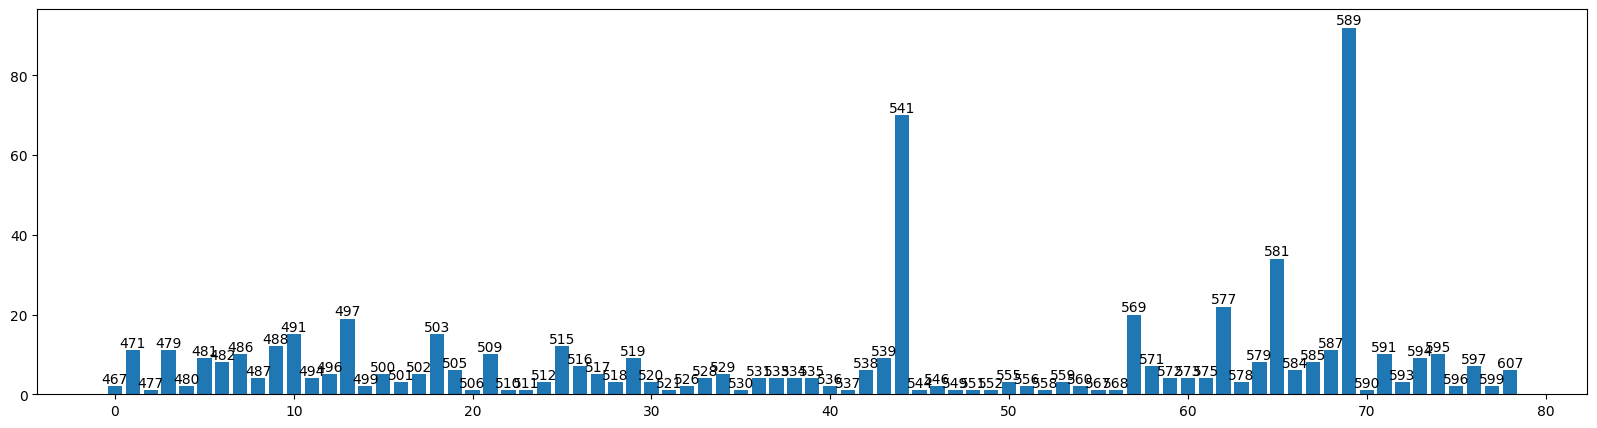

In [14]:
#ogni barra è associata a un grado, sulle y viene indicato quanti nodi hanno quel grado
plt.figure(figsize=(20,5))
barcontainer = plt.bar(range(len(values_unique)),counts)
plt.bar_label(barcontainer,values_unique, label_type='edge')
plt.show()

# Analisi w1

In [15]:
#media e varuianza di tutti i pesi
w = nx.get_node_attributes(G, "w1")
w_list = list(w.values())
print("media pesi:", np.mean(w_list))
print("varianza pesi:", np.var(w_list))

media pesi: 0.019211346059950805
varianza pesi: 0.00010850629613319455


In [16]:
#Valori dei pesi legati a un vertice specifico e ai suoi vicini
means = []
variances = []
for i in range(len(G.nodes)):
    v_index = i
    v = list(G.nodes)[v_index]
    neighbors = list(G.neighbors(v))
    neighbors.append(v)
    G_sub = G.subgraph(neighbors)
    w_sub = nx.get_node_attributes(G_sub, "w1")
    w_list_sub = list(w_sub.values())
    means.append(np.mean(w_list_sub))
    variances.append(np.var(w_list_sub))

In [17]:
means.sort()
variances.sort()

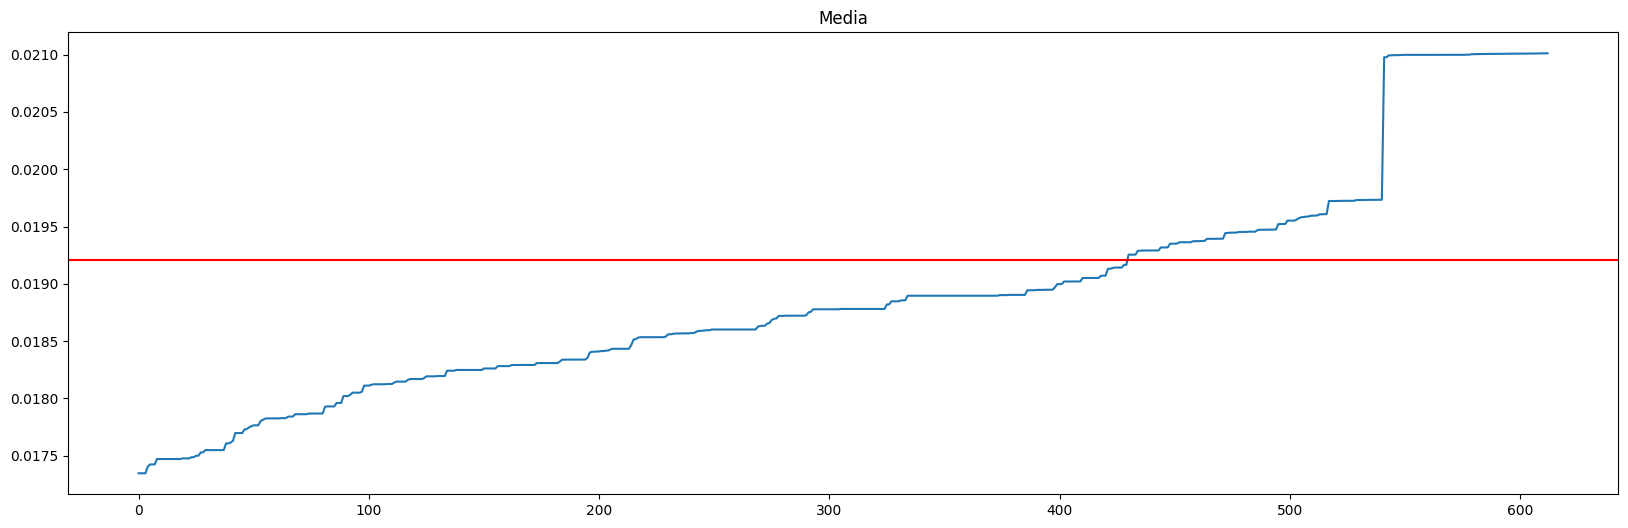

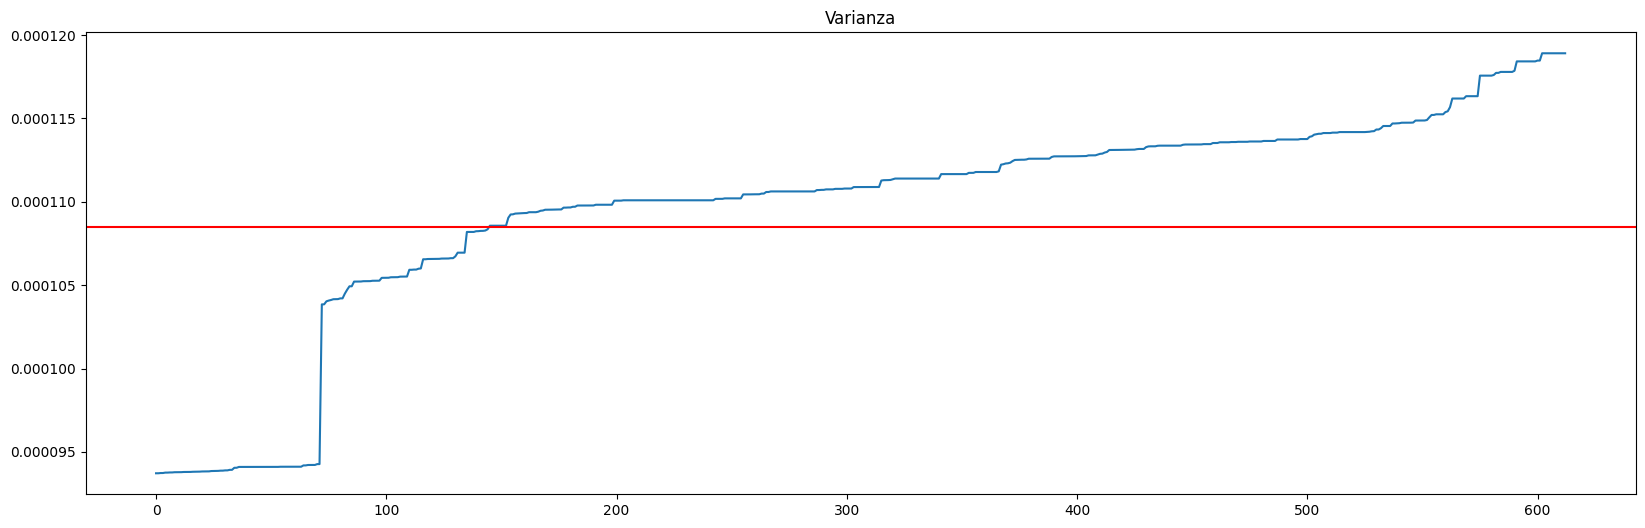

In [18]:
# sulle x ci sono valori fittizzi (però fanno capire quanti valori ci sono prima e dopo la soglia)
# sulle y i valori di media/varianza, la linea rossa è il valore di media/varianza calcolata su tutti i nodi
x = [i for i in range(len(means))]
plt.figure(figsize=(20,6))
plt.plot(x, means)
plt.axhline(y=0.019211346059950805, color='r', linestyle='-')
plt.title("Media")
plt.show()

plt.figure(figsize=(20,6))
plt.plot(x, variances)
plt.axhline(y=0.00010850629613319455, color='r', linestyle='-')
plt.title("Varianza")
plt.show()


# Miglior analisi dei pesi
### Ogni grafico rappresenta la media o varianza dei pesi di un vertice e dei suoi vicini a distanza 1. Sulle x c'è il rapporto tra la dimensione del vicinato rispetto alla dimensione totale del grafo. Sulle y c'è il valore della media o varinza. La linea rossa è il valore di media/varinza generale calcolata su tutti i pesi

## Funzioni

In [19]:
def sort_2_arr(arr1, arr2):
    sort_1 = []
    sort_2 = []
    buffer_1 = arr1.copy()
    buffer_2 = arr2.copy()
    for i in range(len(arr1)):
        id_1 = buffer_1.index(np.min(buffer_1))
        sort_1.append(buffer_1[id_1])
        sort_2.append(buffer_2[id_1])
        buffer_1.pop(id_1)
        buffer_2.pop(id_1)
    return sort_1, sort_2

In [20]:
def total_mean_var(g, weight):
    w = nx.get_node_attributes(g, weight)
    w_list = list(w.values())
    return np.mean(w_list), np.var(w_list)

def mean_var_ratio(g, weight):
    means = []
    variances = []
    ratio = []
    for i in range(len(g.nodes)):
        v_index = i
        v = list(g.nodes)[v_index]
        neighbors = list(g.neighbors(v))
        neighbors.append(v)
        G_sub = g.subgraph(neighbors)
        w_sub = nx.get_node_attributes(G_sub, weight)
        w_list_sub = list(w_sub.values())
        means.append(np.mean(w_list_sub))
        variances.append(np.var(w_list_sub))
        ratio.append(len(G_sub.nodes)/len(g.nodes))
    sort_r_mean, sort_m = sort_2_arr(ratio, means)
    sort_r_var, sort_v = sort_2_arr(ratio, variances)
    return sort_r_mean, sort_m, sort_r_var, sort_v

In [21]:
# sulle x ci sono i valori del grado di un nodo rispetto al numero totale di nofi
# sulle y i valori di media/varianza, la linea rossa è il valore di media/varianza calcolata su tutti i nodi
def draw_plots(srm, sm, srv, sv, mean_tot, var_tot):
    plt.figure(figsize=(20,5))
    plt.plot(srm, sm)
    plt.axhline(y=mean_tot, color='r', linestyle='-')
    plt.title("Media plot")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.plot(srm, sv)
    plt.axhline(y=var_tot, color='r', linestyle='-')
    plt.title("Varianza plot")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.scatter(srm, sm)
    plt.axhline(y=mean_tot, color='r', linestyle='-')
    plt.title("Media scatter")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.scatter(srv, sv)
    plt.axhline(y=var_tot, color='r', linestyle='-')
    plt.title("Varianza scatter")
    plt.show()

## Analisi w1

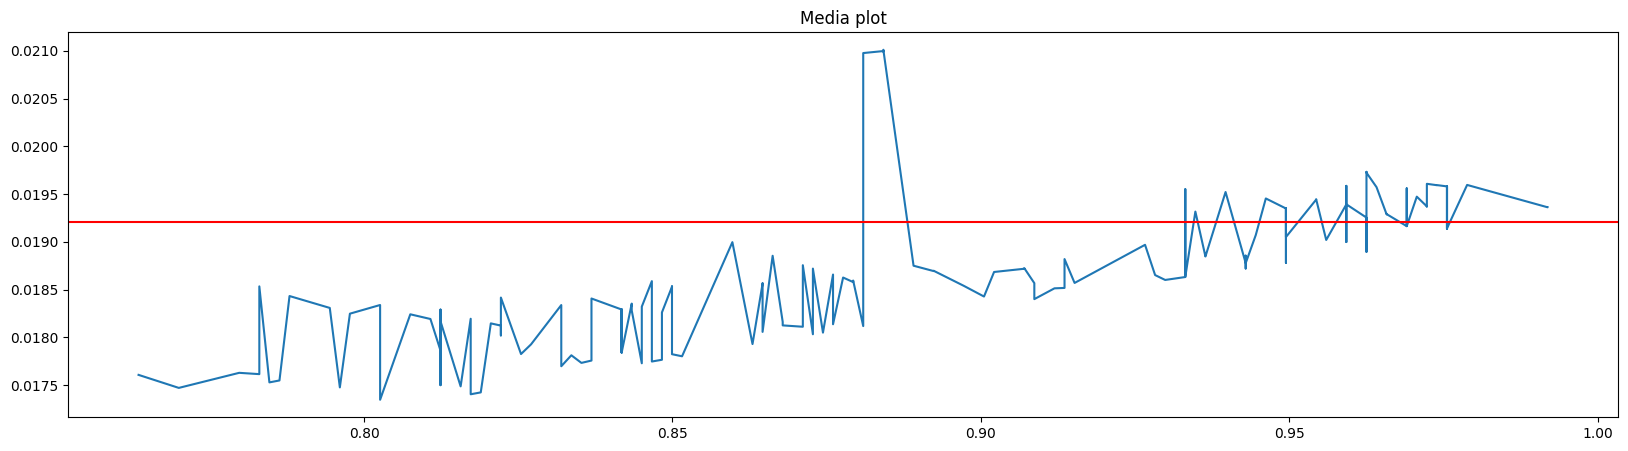

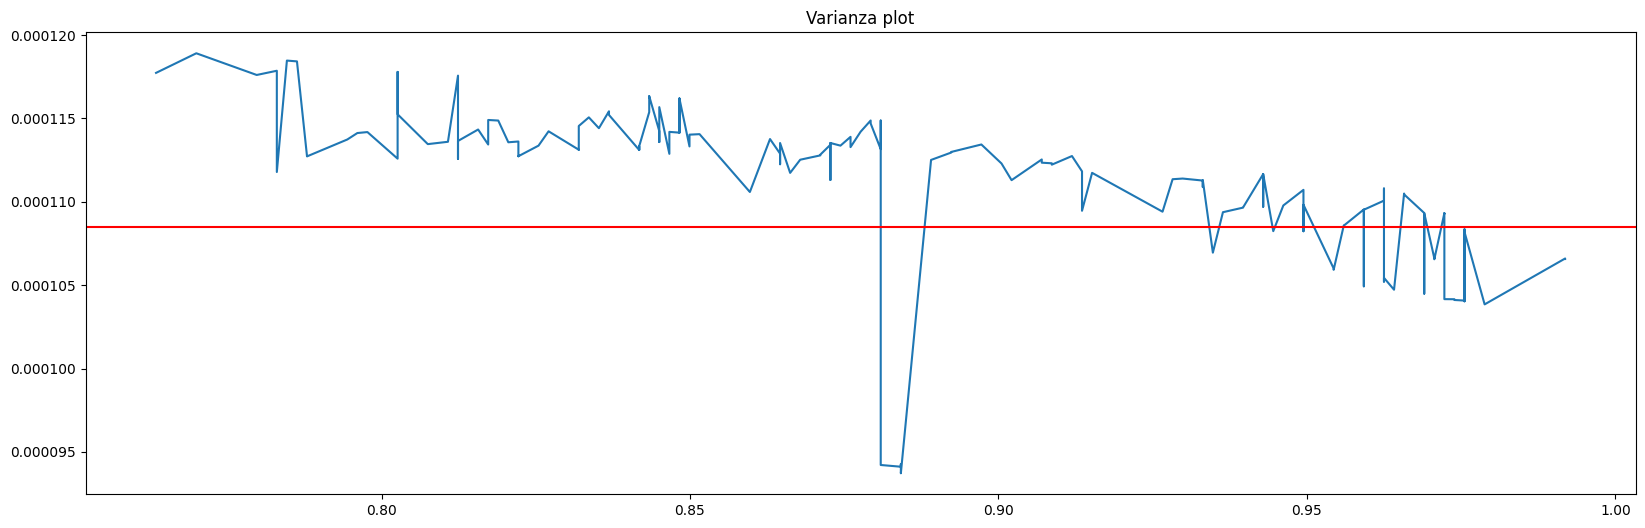

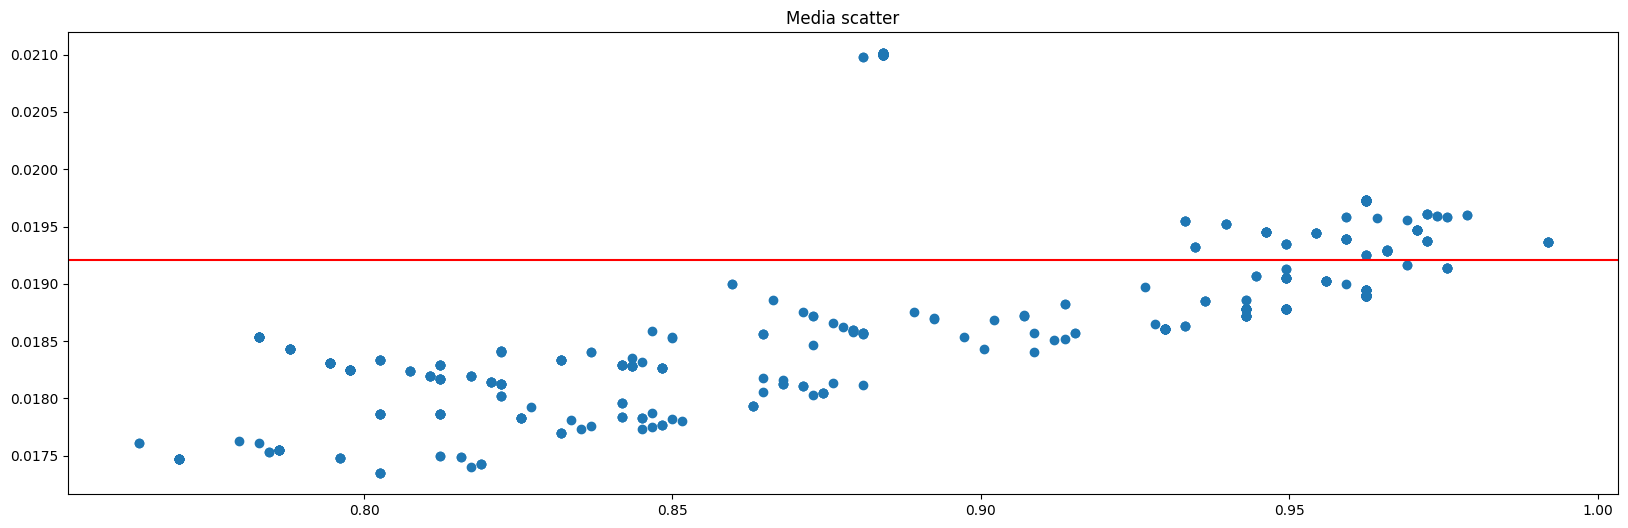

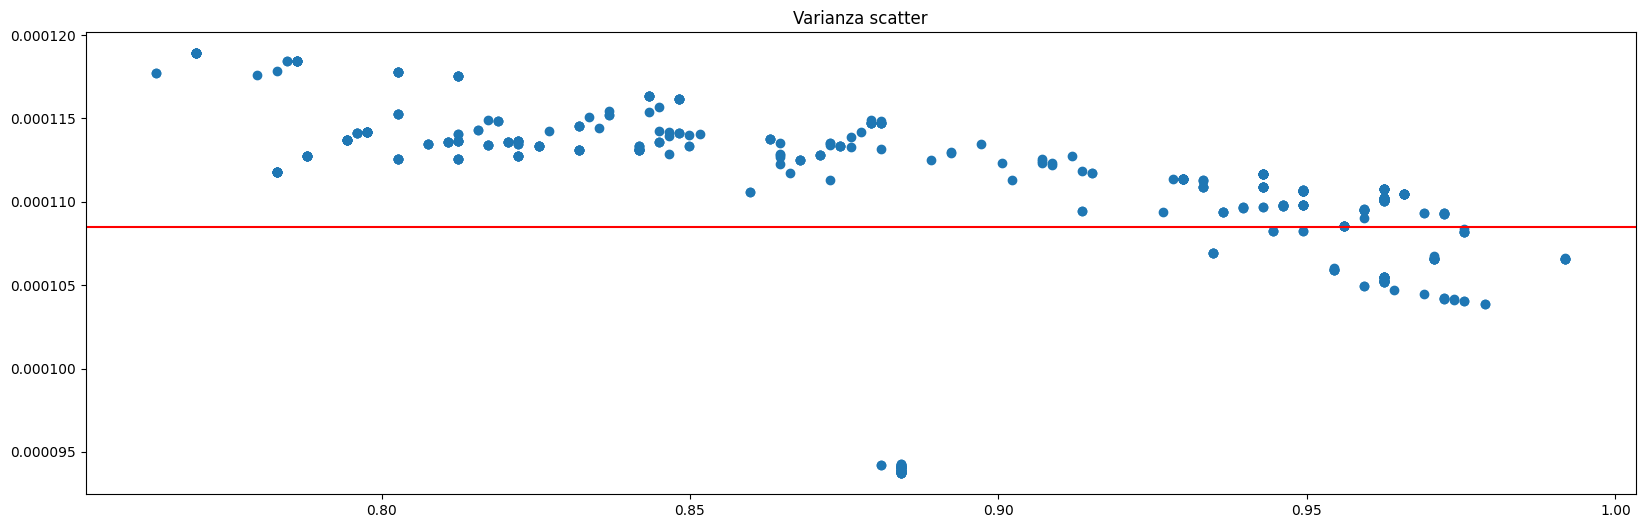

In [22]:
sort_ratio_mean, sort_mean, sort_ratio_var, sort_var = mean_var_ratio(G, 'w1')
tot_mean, tot_var = total_mean_var(G, "w1")
draw_plots(sort_ratio_mean, sort_mean, sort_ratio_var, sort_var, tot_mean, tot_var)

## Anasili w2

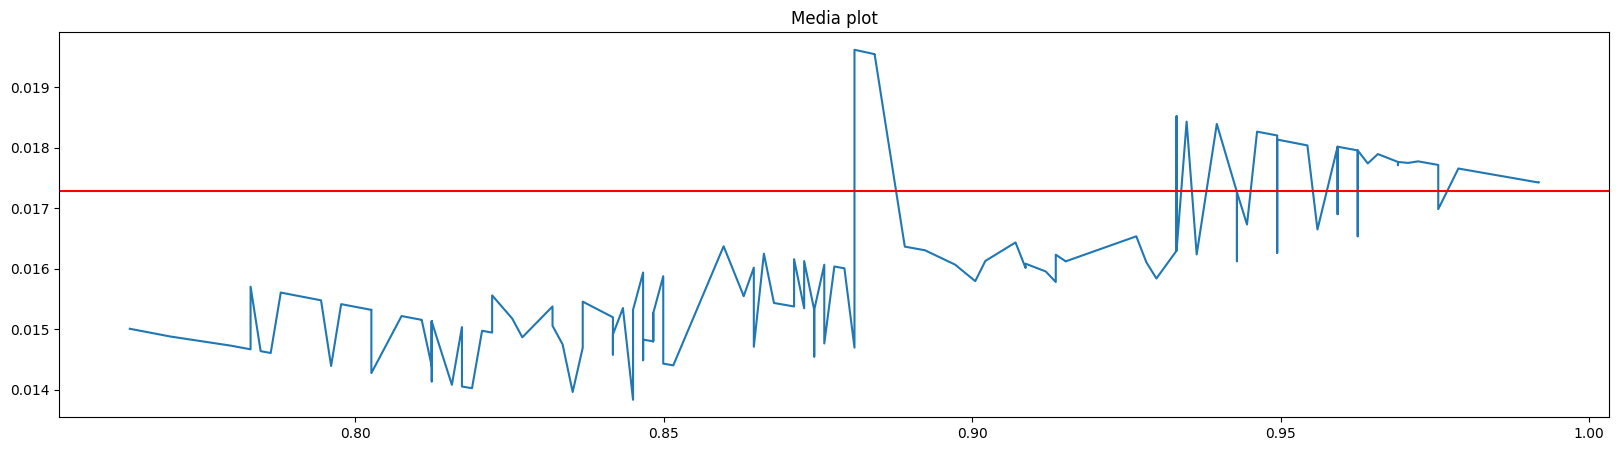

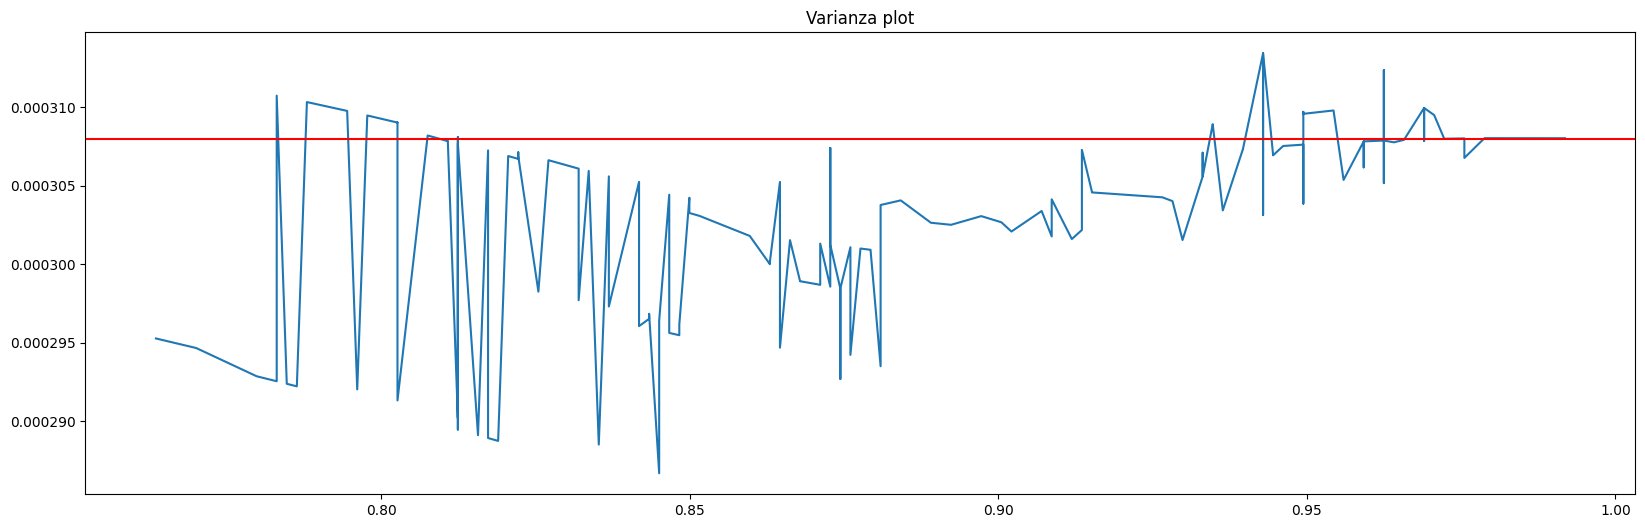

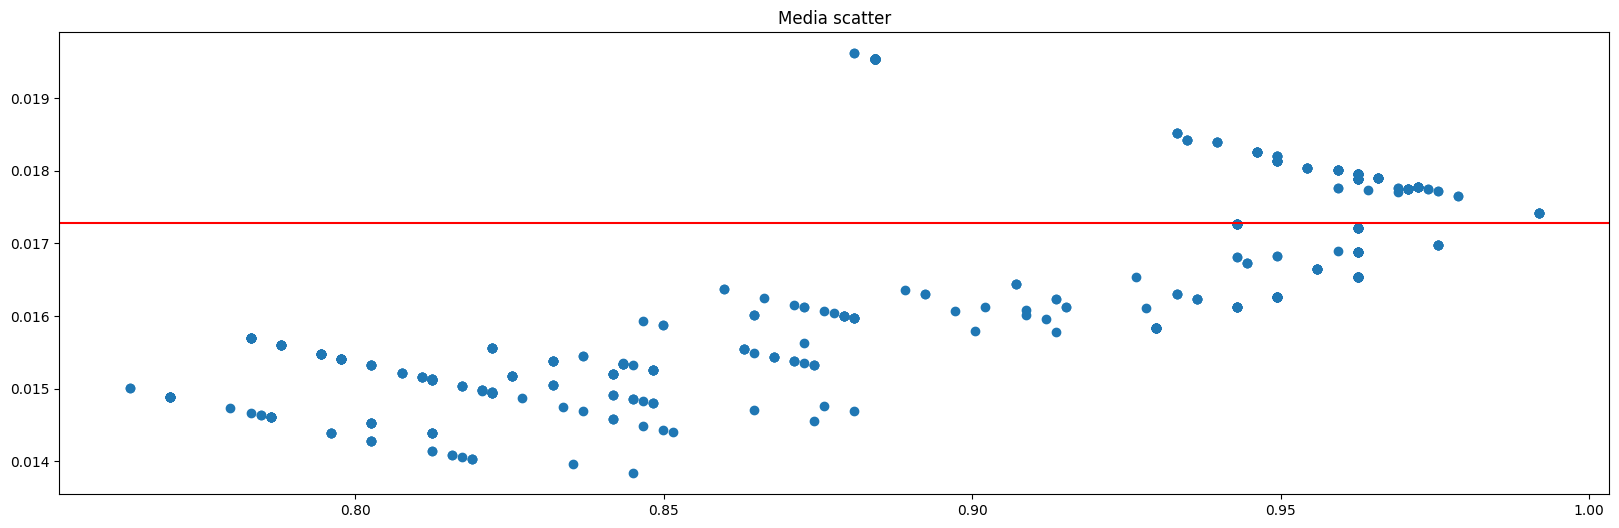

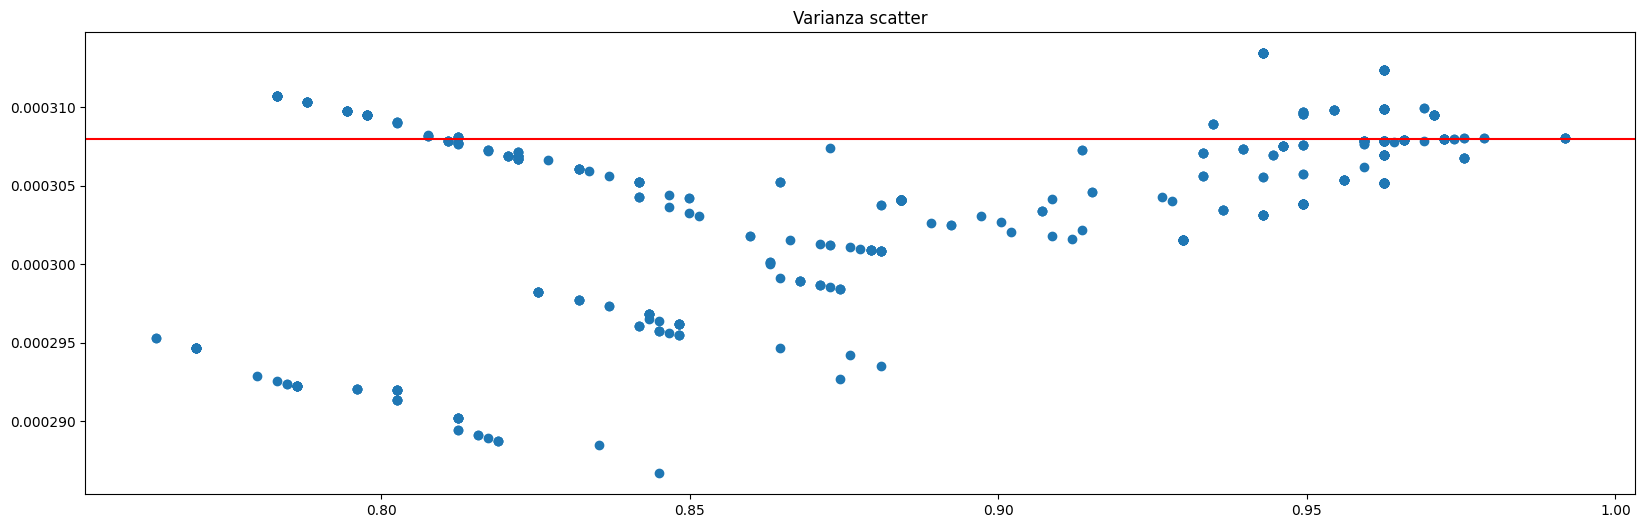

In [23]:
sort_ratio_mean, sort_mean, sort_ratio_var, sort_var = mean_var_ratio(G, 'w2')
tot_mean, tot_var = total_mean_var(G, "w2")
draw_plots(sort_ratio_mean, sort_mean, sort_ratio_var, sort_var, tot_mean, tot_var)

## Anlisi w3=w4

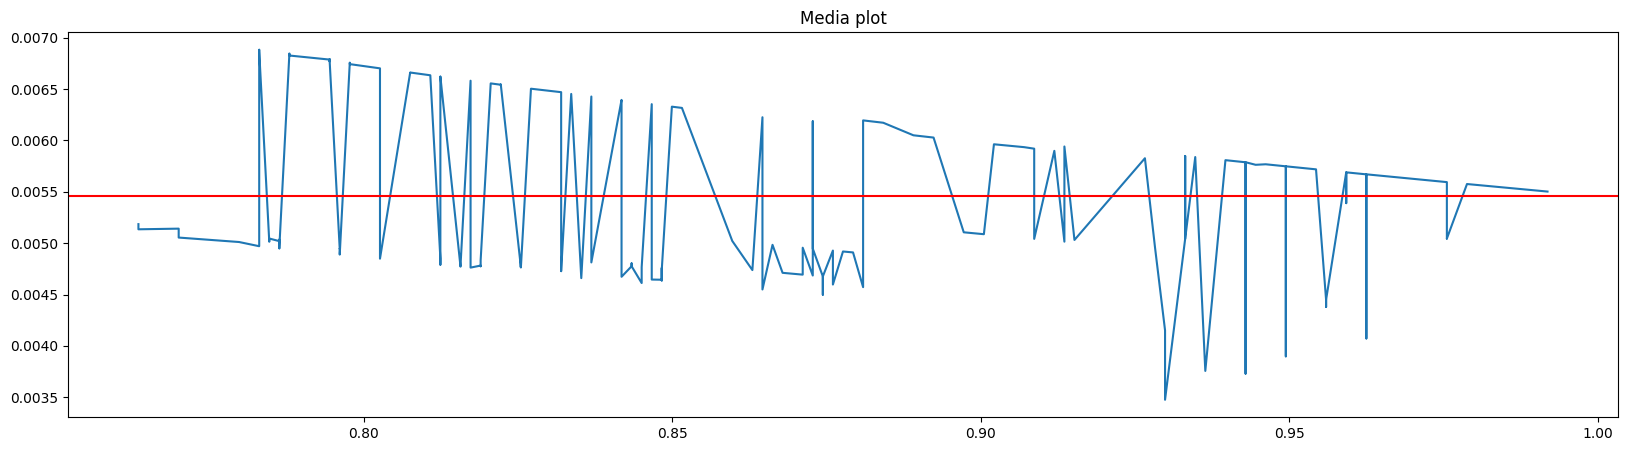

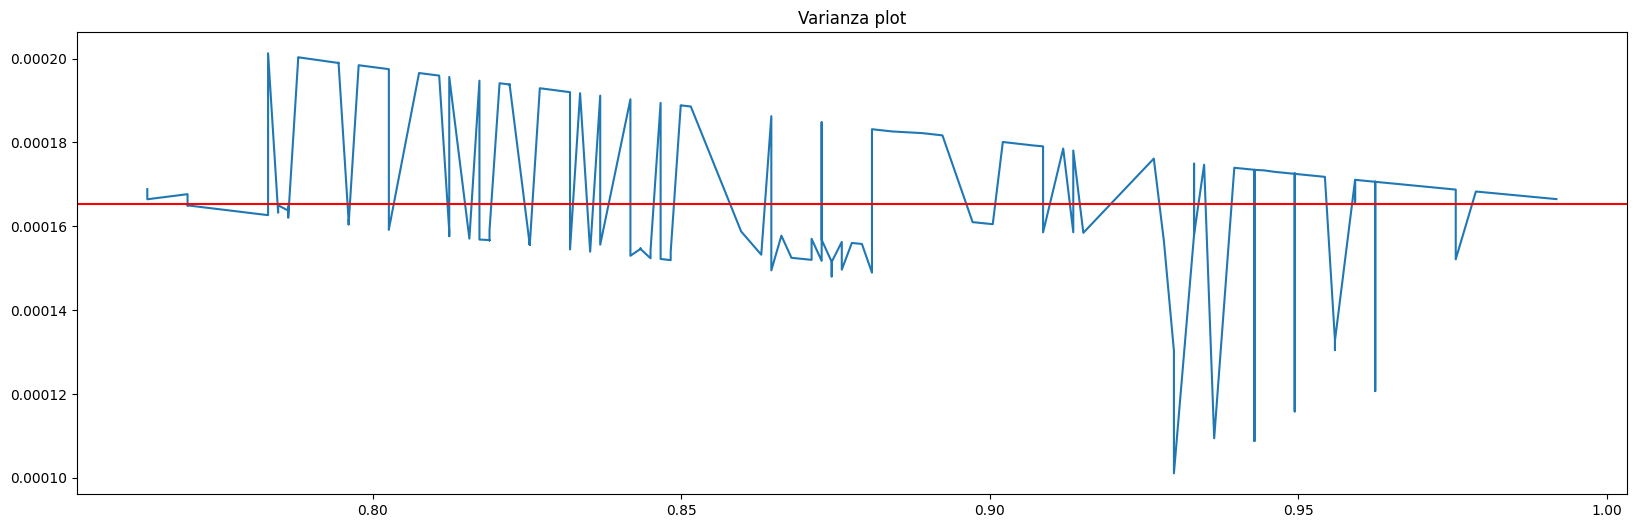

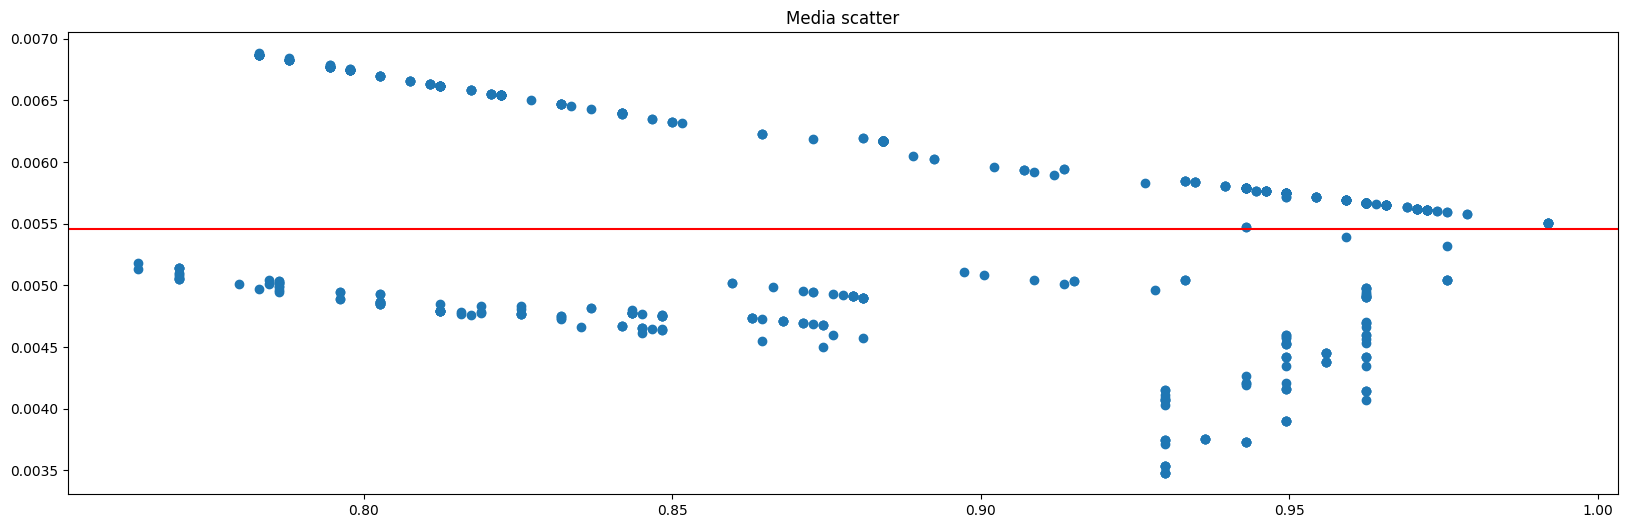

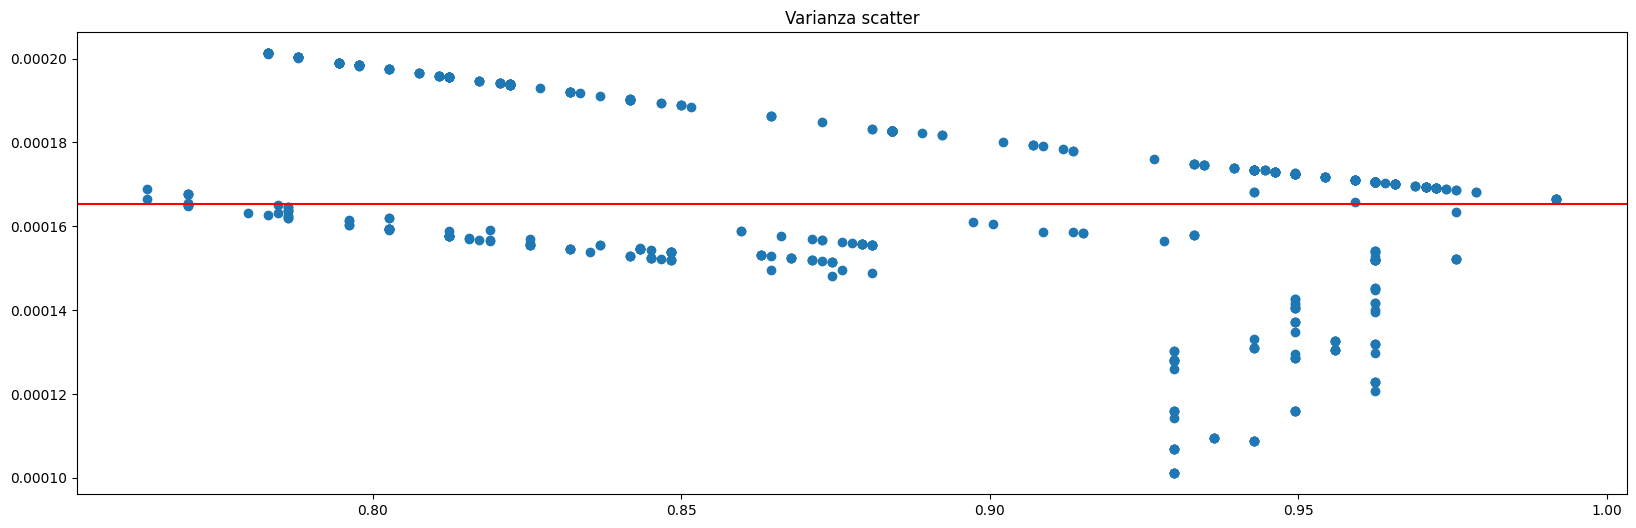

In [24]:
sort_ratio_mean, sort_mean, sort_ratio_var, sort_var = mean_var_ratio(G, 'w3')
tot_mean, tot_var = total_mean_var(G, "w3")
draw_plots(sort_ratio_mean, sort_mean, sort_ratio_var, sort_var, tot_mean, tot_var)

# Altra analisi sui pesi
### Ogni grafico rappresenta il peso di un vertice. Sulle x c'è il rapporto tra il grado del verice rispetto alla dimensione totale del grafo. Sulle y c'è il valore del peso. La linea rossa è il valore di media/varinza generale calcolata su tutti i pesi


## Funzioni

In [25]:
def sort_3_arr(arr1, arr2, arr3):
    sort_1 = []
    sort_2 = []
    sort_3 = []
    buffer_1 = arr1.copy()
    buffer_2 = arr2.copy()
    buffer_3 = arr3.copy()
    for i in range(len(arr1)):
        id_1 = buffer_1.index(np.min(buffer_1))
        sort_1.append(buffer_1[id_1])
        sort_2.append(buffer_2[id_1])
        sort_3.append(buffer_3[id_1])
        buffer_1.pop(id_1)
        buffer_2.pop(id_1)
        buffer_3.pop(id_1)
    return sort_1, sort_2, sort_3

In [26]:
def weight_ratio(g, weight):
    w = []
    ratio = []
    node = []
    all_w = nx.get_node_attributes(g, weight) 
    for v in g.nodes():
        w_of_v = all_w[v]
        degree = g.degree(v)
        ratio.append(degree/len(g.nodes))
        w.append(w_of_v)
        node.append(v)
    sort_r, sort_w, sort_n = sort_3_arr(ratio, w, node)
    return sort_r, sort_w, sort_n

In [27]:
def draw_plots_weight_ratio(sr, sw, mean_tot):
    plt.figure(figsize=(20,5))
    plt.plot(sr, sw)
    plt.axhline(y=mean_tot, color='r', linestyle='-')
    plt.title("Pesi su rapporto")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.scatter(sr, sw)
    plt.axhline(y=mean_tot, color='r', linestyle='-')
    plt.title("Pesi su rapporto scatter")
    plt.show()

## Analisi w1

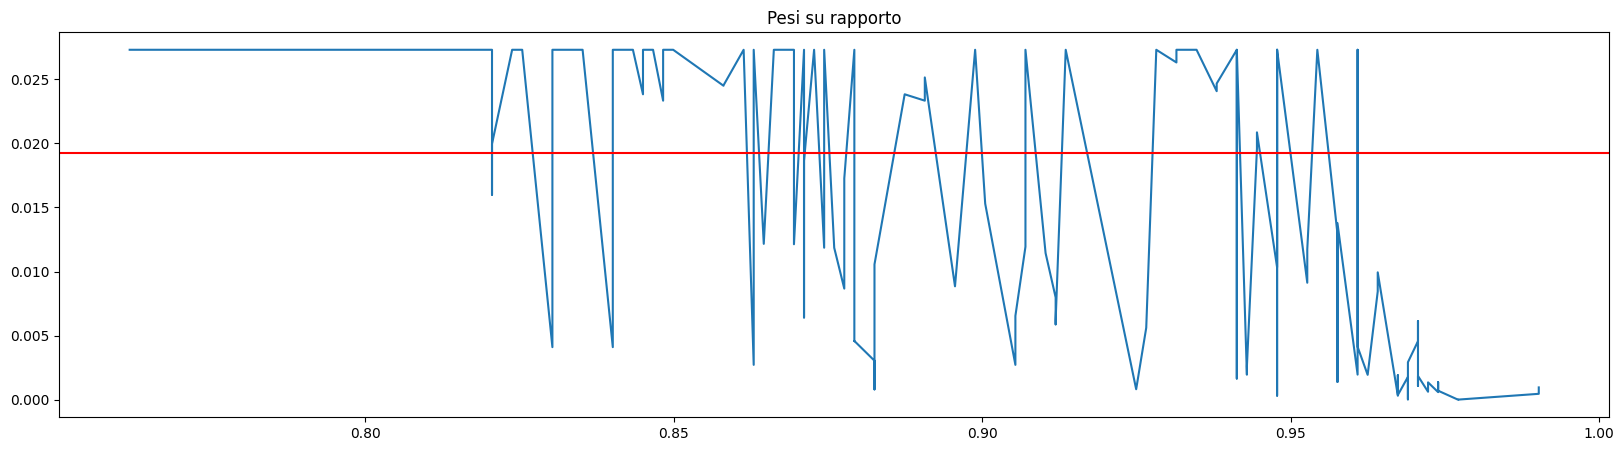

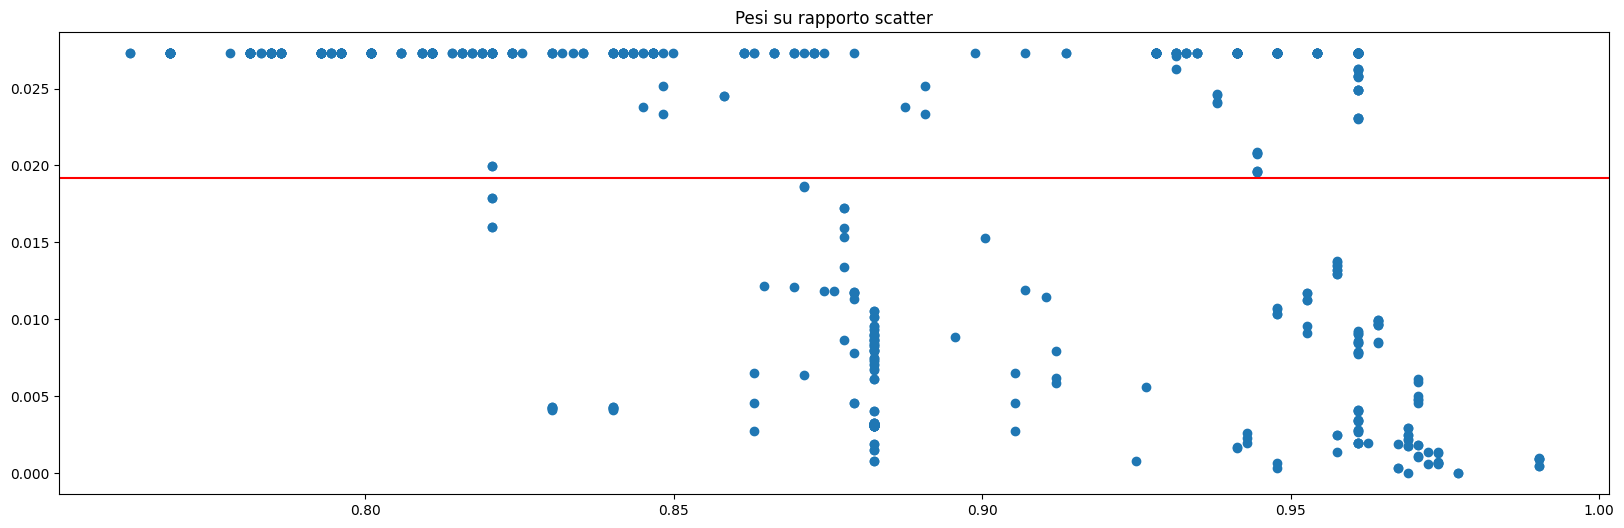

In [28]:
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w1')
tot_mean, tot_var = total_mean_var(G, "w1")
draw_plots_weight_ratio(sort_ratio, sort_weight, tot_mean)

## Analisi w2

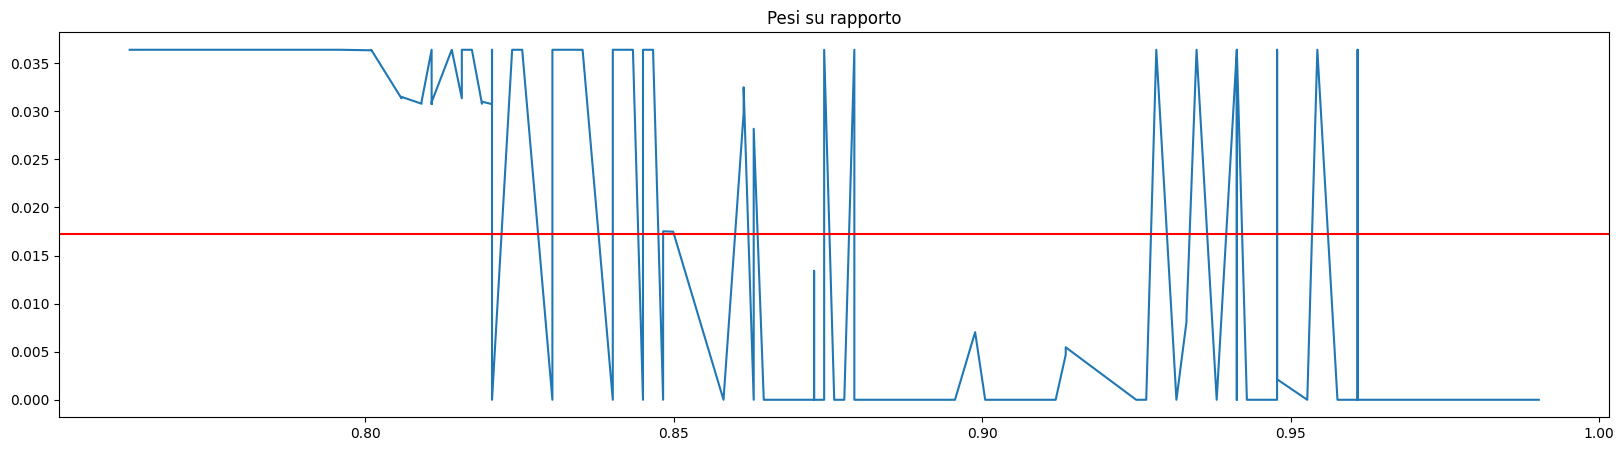

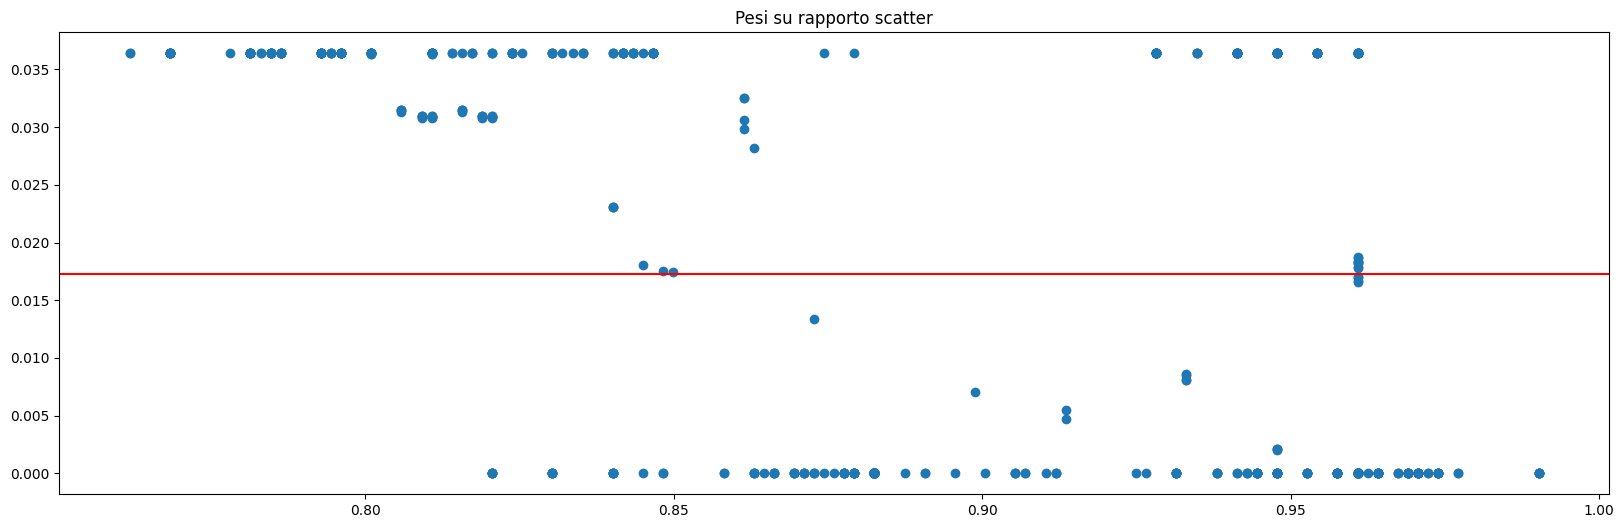

In [29]:
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w2')
tot_mean, tot_var = total_mean_var(G, "w2")
draw_plots_weight_ratio(sort_ratio, sort_weight, tot_mean)

## Analisi w3=w4

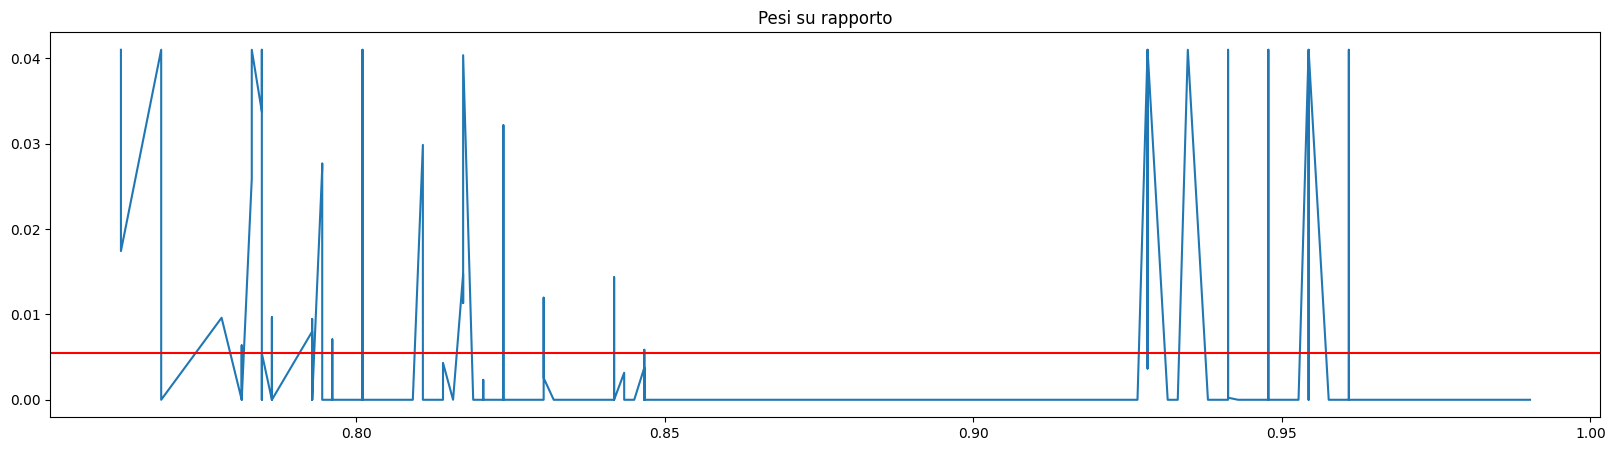

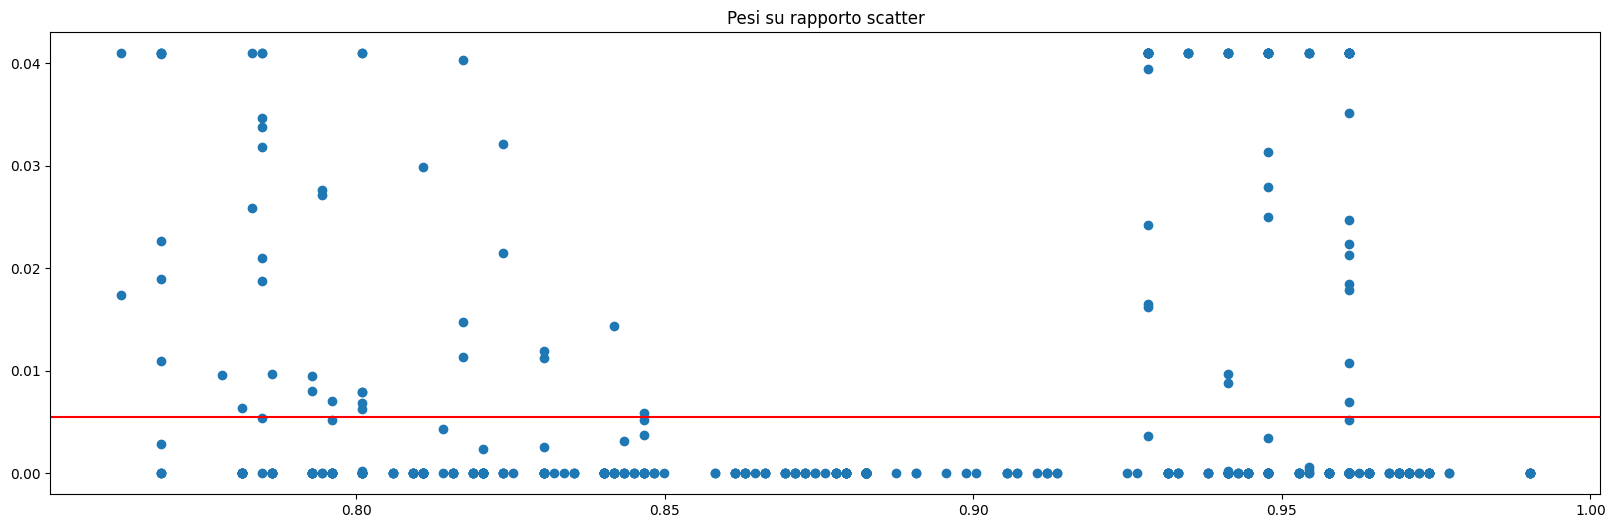

In [30]:
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w3')
tot_mean, tot_var = total_mean_var(G, "w3")
draw_plots_weight_ratio(sort_ratio, sort_weight, tot_mean)

# Estrapolazioni valori

In [31]:
import pandas as pd

In [32]:
#w1
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w1')
sort_weight = ['{:6f}'.format(x) for x in sort_weight]
data = {'ratio': sort_ratio , 'weight': sort_weight, 'node': sort_names }
df= pd.DataFrame(data)
df.to_csv('./ratio_w1.csv', sep=';')

In [33]:
#w2
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w2')
sort_weight = ['{:6f}'.format(x) for x in sort_weight]
data = {'ratio': sort_ratio , 'weight': sort_weight, 'node': sort_names }
df= pd.DataFrame(data)
df.to_csv('./ratio_w2.csv', sep=';')

In [34]:
#w3
sort_ratio, sort_weight, sort_names = weight_ratio(G, 'w3')
sort_weight = ['{:6f}'.format(x) for x in sort_weight]
data = {'ratio': sort_ratio , 'weight': sort_weight, 'node': sort_names }
df= pd.DataFrame(data)
df.to_csv('./ratio_w3.csv', sep=';')

# Analisi pesi
### In questa parte calcolo i valori minimi e massimi dei pesi in funzione di w00 e W01, per poi dividerli in 4 categorie:
### 0: valore peso 0
### 1: valore peso minore di metà range
### 2: valore peso maggiore di metà range
### 3: valore peso massimo
### Su ogni nodo, per ogni peso, vengono calcolati vari valori dei nodi e analizzati

## Grafici Andamento pesi

In [35]:
def w_array(k):
    a=0
    b=0.027290137282490516
    c=d=0.03640364796375065
    e=f=0.08197120137005134
    w1 = [min(max((k[i]-a),0), b) for i in range(len(k))]
    w2 = [min(max(k[i]-c, 0), d) for i in range(len(k))]
    w3 = [min(max((k[i]-e)*0.5,0), f*0.5) for i in range(len(k))]
    return w1, w2, w3

In [36]:
#creo vettore di peso w_tilde_0 e w_tilde_1 con valori da 0 a 1 con scarto 0.001, sono lo stesso vettore perchè comprende tutti i valori possibili
x = [i for i in range(0,1000,1)]
w_tilde = [i/1000 for i in x]
w1_vec, w2_vec, w3_vec = w_array(w_tilde)

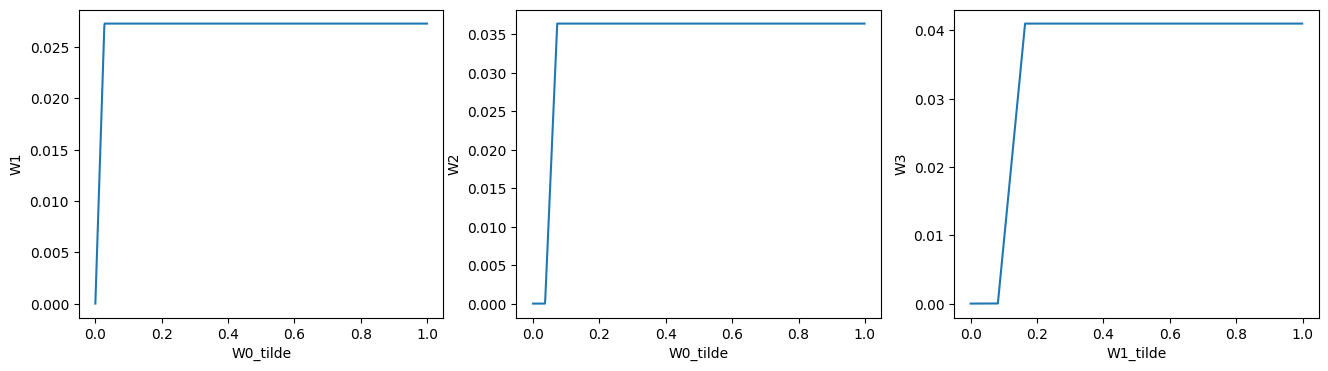

In [37]:
#plot
figure, axis = plt.subplots(1, 3)
figure.set_size_inches(16,4)
axis[0].plot(w_tilde, w1_vec)
axis[0].set_ylabel("W1")
axis[0].set_xlabel("W0_tilde")
axis[1].plot(w_tilde, w2_vec)
axis[1].set_ylabel("W2")
axis[1].set_xlabel("W0_tilde")
axis[2].plot(w_tilde, w3_vec)
axis[2].set_ylabel("W3")
axis[2].set_xlabel("W1_tilde")

plt.show()

## Calcoli

In [6]:
a=0
b=0.027290137282490516
c=d=0.03640364796375065
e=f=0.08197120137005134
w1_min = min(max(0-a, 0), b)
w2_min = min(max(0-c, 0), d)
w3_min = min(max((0-e)*0.5,0), f*0.5)
w1_max = min(max(1-a, 0), b)
w2_max = min(max(1-c, 0), d)
w3_max = min(max((1-e)*0.5,0), f*0.5)
w1_med = (w1_max+w1_min)/2
w2_med = (w2_max+w2_min)/2
w3_med = (w3_max+w3_min)/2
print(f"W1: min= {w1_min}, max={w1_max:.4f}=b, med= {w1_med:.4f}")
print(f"W2: min= {w2_min}, max={w2_max:.4f}=c=d, med= {w2_med:.4f}")
print(f"W3: min= {w3_min}, max={w3_max:.4f}=e/2=f/2, med= {w3_med:.4f}")

W1: min= 0, max=0.0273=b, med= 0.0136
W2: min= 0, max=0.0364=c=d, med= 0.0182
W3: min= 0, max=0.0410=e/2=f/2, med= 0.0205


## Pesi divisi in classi rispetto a varie metriche

In [39]:
# fare funzione che mette le classi per i pesi estraendo i pesi giusti
sort_ratio_w1, sort_weight_w1, sort_name_w1 = weight_ratio(G, "w1")
sort_ratio_w2, sort_weight_w2, sort_name_w2 = weight_ratio(G, "w2")
sort_ratio_w3, sort_weight_w3, sort_name_w3 = weight_ratio(G, "w3")

In [40]:
def class_weight(sort_w, med, max):
    class_w = [0 for i in range(len(sort_w))]
    for i in range(len(sort_w)):
        if sort_w[i] == 0 :
            class_w[i] = 0
        elif sort_w[i]>0 and sort_w[i]<med:
            class_w[i] = 1
        elif sort_w[i]>=med and sort_w[i]<max:
            class_w[i] = 2
        else:
            class_w[i] = 3
    return class_w

class_w1 = class_weight(sort_weight_w1, w1_med, w1_max)
class_w2 = class_weight(sort_weight_w2, w2_med, w2_max)
class_w3 = class_weight(sort_weight_w3, w3_med, w3_max)

In [41]:
betw_dict = nx.betweenness_centrality(G)
eig_dict = nx.eigenvector_centrality(G)
core_dict = nx.core_number(G)

In [39]:
def calculate_metrics(g, sort_name, betw, eig, core):   
    closeness = []
    betweeness = []
    eigvector = []
    cluster = []
    k_core = []
    for i in sort_name:
        #valuta la capacità di un nodo di diffondere informazioni rapidamente in tutto il grafo.
        closeness.append(nx.closeness_centrality(g,i))
        #è una misura di quante volte un nodo funge da "ponte" nel percorso più breve tra due altri nodi
        betweeness.append(betw[i])
        #misura quanto un nodo è importante non solo in base ai suoi collegamenti, ma anche in base all'importanza dei nodi a cui è collegato.
        eigvector.append(eig[i])
        #misura quanto un nodo tende a formare triangoli, quindi la "densità" locale della rete intorno a un nodo.
        cluster.append(nx.clustering(g,i))
        #Il core number di un nodo in un grafo è un numero intero che descrive il massimo valore di k per cui quel nodo appartiene a un k-core.
        #Un k-core è un sottografo massimo del grafo originale in cui ogni nodo ha almeno k collegamenti
        k_core.append(core[i])
    return closeness,betweeness, eigvector, cluster, k_core

closeness_w1 ,betweeness_w1, eigvector_w1, cluster_w1, k_core_w1 = calculate_metrics(G, sort_name_w1, betw_dict, eig_dict, core_dict)
closeness_w2 ,betweeness_w2, eigvector_w2, cluster_w2, k_core_w2 = calculate_metrics(G, sort_name_w2, betw_dict, eig_dict, core_dict)
closeness_w3 ,betweeness_w3, eigvector_w3, cluster_w3, k_core_w3 = calculate_metrics(G, sort_name_w3, betw_dict, eig_dict, core_dict)

In [50]:
data_w1 = {"Ratio":sort_ratio_w1, "W1":class_w1, "Name":sort_name_w1, "Closeness":closeness_w1, 
           "Betweeness":betweeness_w1, "Eigvector centrality":eigvector_w1, "Cluster coifficent": cluster_w1, "K-core number":k_core_w1 }
data_w2 = {"Ratio":sort_ratio_w2, "W2":class_w2, "Name":sort_name_w2, "Closeness":closeness_w2, 
           "Betweeness":betweeness_w2, "Eigvector centrality":eigvector_w2, "Cluster coifficent": cluster_w2, "K-core number":k_core_w2 }
data_w3 = {"Ratio":sort_ratio_w3, "W3":class_w3, "Name":sort_name_w3, "Closeness":closeness_w3, 
           "Betweeness":betweeness_w3, "Eigvector centrality":eigvector_w3, "Cluster coifficent": cluster_w3, "K-core number":k_core_w3 }
dataframe_w1 = pd.DataFrame(data_w1)
dataframe_w2 = pd.DataFrame(data_w2)
dataframe_w3 = pd.DataFrame(data_w3)

In [51]:
dataframe_w1.to_csv("./values_w1.csv", sep=";")
dataframe_w2.to_csv("./values_w2.csv", sep=";")
dataframe_w3.to_csv("./values_w3.csv", sep=";")

In [51]:
w1 = list(nx.get_node_attributes(G,'w1').values())
w1 = ['{:6f}'.format(x) for x in w1]
w2 = list(nx.get_node_attributes(G,'w2').values())
w3 = list(nx.get_node_attributes(G,'w3').values())
data_w = {"w1":w1, "w2":w2, "w3":w3}
dataframe_w = pd.DataFrame(data_w)
dataframe_w.to_csv("./values_w.csv", sep=";")

# Estrapolazione W00 e W01

In [117]:
name =[int(key) for key in graph_data['vertices']]
w00 = [graph_data['vertices'][key][0] for key in graph_data['vertices']]
w01 = [graph_data['vertices'][key][1] for key in graph_data['vertices']]
degrees = [G.degree()[k]/len(G) for k in name]
degrees = np.round(degrees, 3)
w00 = np.round(w00, 4)
w01 = np.round(w01, 4)

In [118]:
def crea_matrice_probabilita(rapporti, pesi):
    # Ottieni i valori unici di rapporti e pesi
    rapporti_unici = sorted(set(rapporti))
    pesi_unici = sorted(set(pesi))

    # Crea una matrice vuota per le probabilità
    matrice_probabilita = np.zeros((len(rapporti_unici), len(pesi_unici)))

    # Crea un DataFrame per una migliore gestione
    df = pd.DataFrame({'rapporto': rapporti, 'peso': pesi})

    # Calcola la probabilità per ogni combinazione rapporto-peso
    for i, rapporto in enumerate(rapporti_unici):
        for j, peso in enumerate(pesi_unici):
            # Conta quante volte il rapporto è associato a quel peso
            count = len(df[(df['rapporto'] == rapporto) & (df['peso'] == peso)])
            # Calcola la probabilità e la inserisce nella matrice
            matrice_probabilita[i, j] = count

    # Creare un DataFrame per visualizzare la matrice
    matrice_prob_df = pd.DataFrame(matrice_probabilita, index=rapporti_unici, columns=pesi_unici)

    righe_somma = matrice_prob_df.sum(axis=1)  # Somma di ogni riga
    matrice_prob_df = matrice_prob_df.div(righe_somma, axis=0)

    return matrice_prob_df

In [119]:
matrice_w00 = crea_matrice_probabilita(degrees, w00)
matrice_w01 = crea_matrice_probabilita(degrees, w01)

In [121]:
matrice_w00.to_csv('prob_w00.csv', index=True)
matrice_w01.to_csv('prob_w01.csv', index=True)

In [12]:
np_matrice_w0 = matrice_w00.to_numpy()
np_matrice_w1 = matrice_w01.to_numpy()

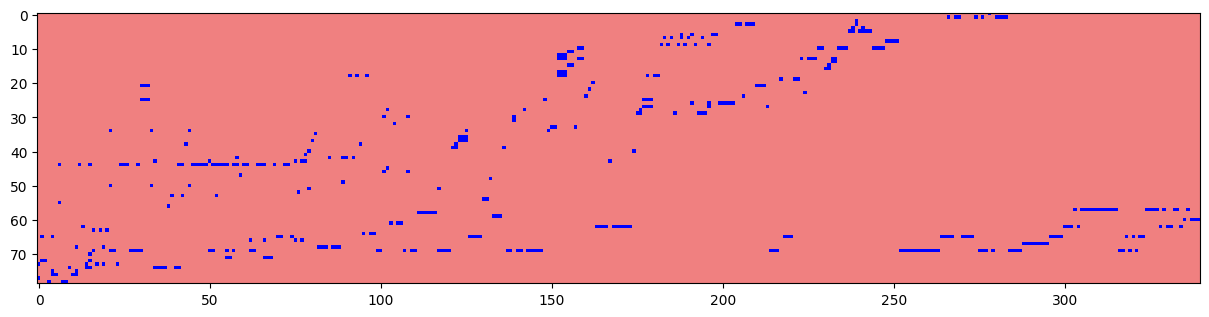

In [13]:
cmap = plt.cm.colors.ListedColormap(['lightcoral', 'blue'])
# Creiamo una matrice "binaria" dove i valori 0 saranno 0 (rosso) e i valori non-zero saranno 1 (blu)
binary_matrix = np.where(np_matrice_w0 == 0, 0, 1)

plt.figure(figsize=(15,20))
# Disegna la matrice binaria con i colori definiti
plt.imshow(binary_matrix, cmap=cmap, interpolation='none')
# Aggiungi una griglia facoltativa
plt.grid(False)
# Mostra la matrice colorata
plt.show()

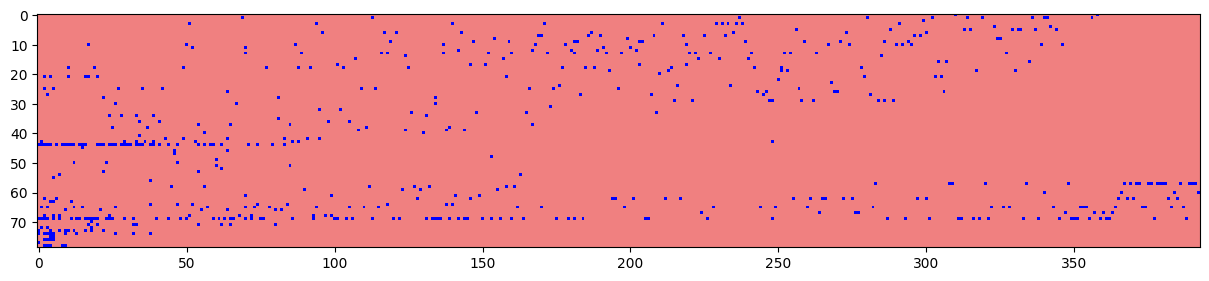

In [14]:
cmap = plt.cm.colors.ListedColormap(['lightcoral', 'blue'])
# Creiamo una matrice "binaria" dove i valori 0 saranno 0 (rosso) e i valori non-zero saranno 1 (blu)
binary_matrix = np.where(np_matrice_w1 == 0, 0, 1)

plt.figure(figsize=(15,20))
# Disegna la matrice binaria con i colori definiti
plt.imshow(binary_matrix, cmap=cmap, interpolation='none')
# Aggiungi una griglia facoltativa
plt.grid(False)
# Mostra la matrice colorata
plt.show()

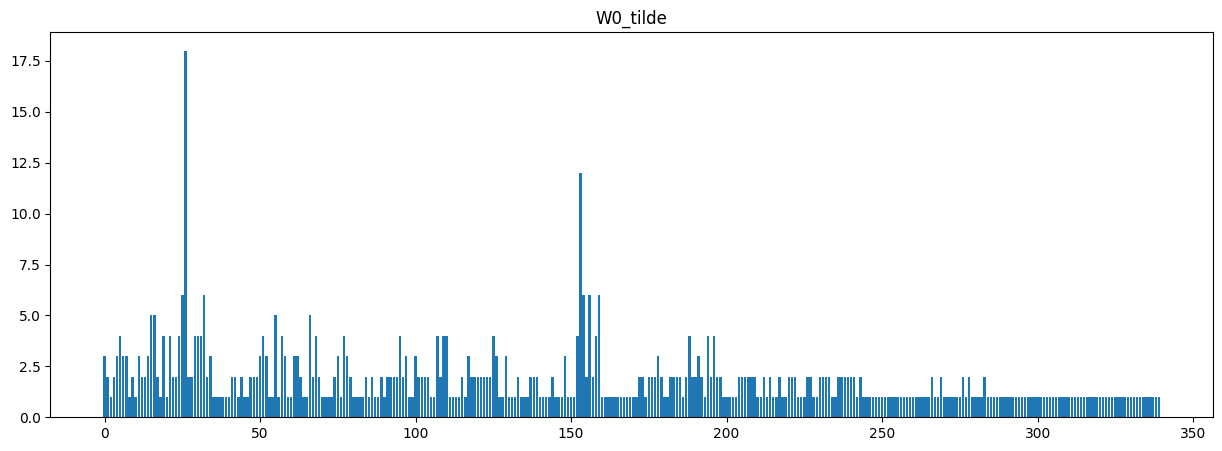

In [29]:
w00_list = list(w00)
w00_list.sort()
values_unique = list(set(w00_list))
values_unique.sort()
counts = [w00_list.count(value) for value in values_unique]
#ogni barra è associata a un grado, sulle y viene indicato quanti nodi hanno quel grado
plt.figure(figsize=(15,5))
plt.title("W0_tilde")
barcontainer = plt.bar(range(len(values_unique)),counts)
plt.show()

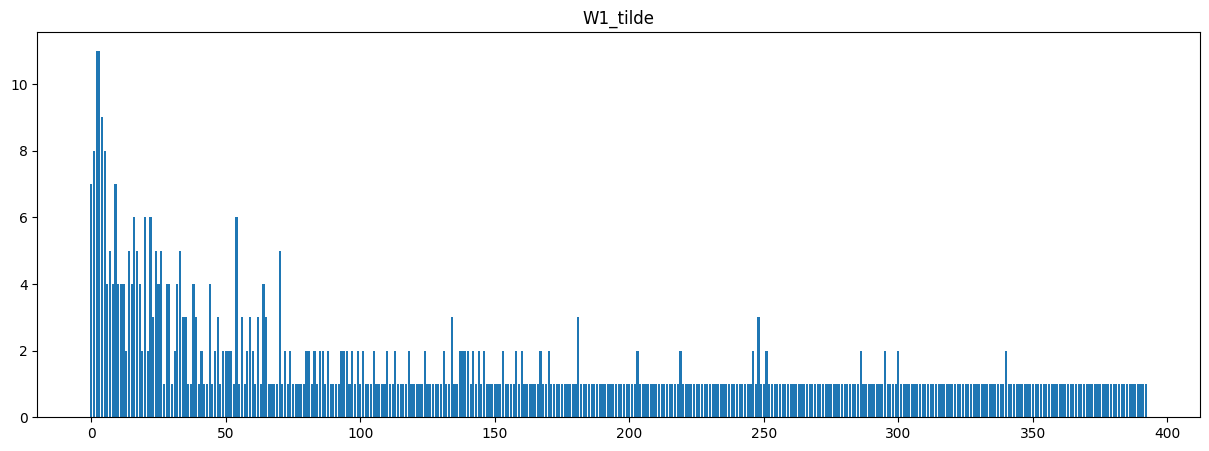

In [28]:
w01_list = list(w01)
w01_list.sort()
values_unique = list(set(w01_list))
values_unique.sort()
counts = [w01_list.count(value) for value in values_unique]
#ogni barra è associata a un grado, sulle y viene indicato quanti nodi hanno quel grado
plt.figure(figsize=(15,5))
plt.title("W1_tilde")
barcontainer = plt.bar(range(len(values_unique)),counts)
plt.show()